In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression

try:
    from xgboost import XGBClassifier, XGBRegressor
except ImportError:
    print("Warning: xgboost not installed; skipping XGB models")
    XGBClassifier = None
    XGBRegressor = None

try:
    from lightgbm import LGBMClassifier, LGBMRegressor
except ImportError:
    print("Warning: lightgbm not installed; skipping LGBM models")
    LGBMClassifier = None
    LGBMRegressor = None


In [16]:
# Data Loading and Preparation ===
df = pd.read_csv(r"C:\My stuff\Coding\ML project\KiranveerSingh_projectfinal\Dataset\feature_engineered_nifty5.csv")
df['Date'] = pd.to_datetime(df['Date'])

split_date = pd.to_datetime('2020-01-01')
train = df[df['Date'] < split_date].copy()
test = df[df['Date'] >= split_date].copy()

exclude_cols = ['Date', 'Symbol', 'Will_Grow']
all_features = [col for col in df.columns if col not in exclude_cols]
numeric_features = df[all_features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = list(set(all_features) - set(numeric_features))

X_train_num = train[numeric_features]
X_test_num = test[numeric_features]
X_train_cat = train[categorical_features]
X_test_cat = test[categorical_features]

# One-hot encode categorical columns
X_train_cat_enc = pd.get_dummies(X_train_cat, drop_first=True)
X_test_cat_enc = pd.get_dummies(X_test_cat, drop_first=True)

# Align columns of train and test to match
X_train_cat_enc, X_test_cat_enc = X_train_cat_enc.align(X_test_cat_enc, join='left', axis=1, fill_value=0)

# Save the list of categorical columns from training data
categorical_columns = X_train_cat_enc.columns.tolist()


# Save to disk for later use during inference
joblib.dump(categorical_columns, r"C:\My stuff\Coding\ML project\KiranveerSingh_projectfinal\Models/X_train_cat_enc_columns.pkl")

print(f"Saved {len(categorical_columns)} categorical columns to 'models/X_train_cat_enc_columns.pkl'")

Saved 0 categorical columns to 'models/X_train_cat_enc_columns.pkl'


In [4]:
# Combine numeric and encoded categorical features
X_train = pd.concat([X_train_num.reset_index(drop=True), X_train_cat_enc.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_num.reset_index(drop=True), X_test_cat_enc.reset_index(drop=True)], axis=1)


In [13]:
# Scale numeric features only
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

y_train_clf = train['Will_Grow']
y_test_clf = test['Will_Grow']

if 'Return_1D' in df.columns:
    y_train_reg = train['Return_1D'].fillna(0)
    y_test_reg = test['Return_1D'].fillna(0)
else:
    train['Next_Close'] = train.groupby('Symbol')['Close'].shift(-1)
    train['Return_1D'] = (train['Next_Close'] - train['Close']) / train['Close']
    test['Next_Close'] = test.groupby('Symbol')['Close'].shift(-1)
    test['Return_1D'] = (test['Next_Close'] - test['Close']) / test['Close']
    y_train_reg = train['Return_1D'].fillna(0)
    y_test_reg = test['Return_1D'].fillna(0)

# Save the scaler for future use
joblib.dump(scaler, r"C:\My stuff\Coding\ML project\KiranveerSingh_projectfinal\Models/scaler.pkl")
print("Scaler saved to 'Models/scaler.pkl'")


Scaler saved to 'Models/scaler.pkl'


In [6]:
# Model Definitions
classification_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42)
}
if XGBClassifier is not None:
    classification_models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
if LGBMClassifier is not None:
    classification_models["LightGBM"] = LGBMClassifier(random_state=42)

regression_models = {
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Linear Regression": LinearRegression()
}
if XGBRegressor is not None:
    regression_models["XGBoost Regressor"] = XGBRegressor(random_state=42)
if LGBMRegressor is not None:
    regression_models["LightGBM Regressor"] = LGBMRegressor(random_state=42)


In [7]:
# Training and Evaluation
classification_results = []
regression_results = []

for name, model in classification_models.items():
    model.fit(X_train, y_train_clf)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    classification_results.append({
        "Model": name,
        "Type": "Classifier",
        "Accuracy": accuracy_score(y_test_clf, y_pred),
        "F1-score": f1_score(y_test_clf, y_pred),
        "model_obj": model
    })

for name, model in regression_models.items():
    model.fit(X_train, y_train_reg)
    y_pred_reg = model.predict(X_test)
    y_pred_class = (y_pred_reg > 0).astype(int)
    regression_results.append({
        "Model": name,
        "Type": "Regressor",
        "Accuracy": accuracy_score(y_test_clf, y_pred_class),
        "F1-score": f1_score(y_test_clf, y_pred_class),
        "model_obj": model
    })

df_clf = pd.DataFrame(classification_results)
df_reg = pd.DataFrame(regression_results)
df_all = pd.concat([df_clf, df_reg], ignore_index=True)


c:\Users\mrran\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:02:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1265, number of negative: 1075
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 2340, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540598 -> initscore=0.162751
[LightGBM] [Info] Start training from score 0.162751
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 2340, number of used features: 28

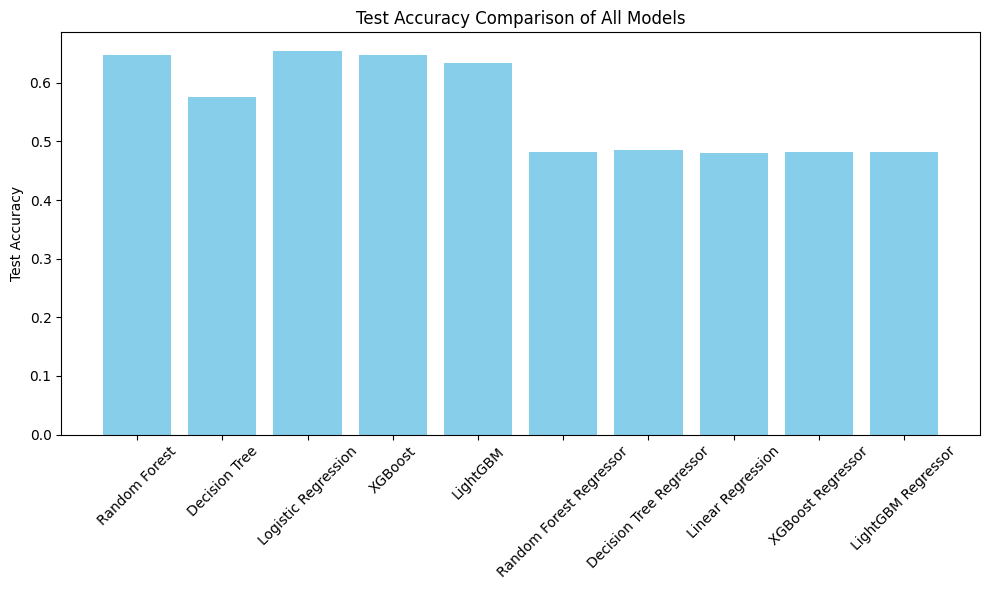

In [8]:
# === 4. Plot Accuracy Comparison ===
plt.figure(figsize=(10, 6))
plt.bar(df_all['Model'], df_all['Accuracy'], color='skyblue')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison of All Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# === 5. Select Best Model (Highest F1-score) and Save ===
best_row = df_all.loc[df_all['F1-score'].idxmax()]
best_model = best_row['model_obj']
best_name = best_row['Model']

print(f"Best model: {best_name} (Type: {best_row['Type']}), F1-score: {best_row['F1-score']:.4f}")

model_path = f"C:\\My stuff\\Coding\\ML project\\KiranveerSingh_projectfinal\\Models\\{best_name}.pkl"

joblib.dump(best_model, model_path)
print(f"Best model saved to: {model_path}")

Best model: XGBoost (Type: Classifier), F1-score: 0.6831
Best model saved to: C:\My stuff\Coding\ML project\KiranveerSingh_projectfinal\Models\XGBoost.pkl
